In [208]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [209]:
path = "./ORL3232/"
folders = sorted(os.listdir(path)[:-1], key = lambda x : int(x))

imgs = []
labels = []

for folder in folders:
    p = path + folder + '/'
    files = os.listdir(p)
    files = [p+x for x in files if x.endswith(".bmp")]
    for file in files:
        img = cv2.imread(file, 0) / 255.0
        #img = img.reshape([-1])
        imgs.append(np.reshape(img, [32, 32, 1]))
        labels.append(int(folder) - 1)

print("done")

done


In [210]:
x_data = imgs.copy() * 2
y_data = labels.copy() * 2

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1207)

x_train = tf.constant(x_train, dtype=tf.float32)
x_test = tf.constant(x_test, dtype=tf.float32)
y_train = tf.one_hot(y_train, len(folders))
y_test = tf.one_hot(y_test, len(folders))

assert x_train.shape[0] == y_train.shape[0]
assert x_test.shape[0] == y_test.shape[0]

In [211]:
class Model(keras.models.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pool = keras.layers.MaxPool2D()
        self.flat = keras.layers.Flatten()
        self.conv1 = keras.layers.Conv2D(32, 3, activation=tf.nn.relu)
        self.conv2 = keras.layers.Conv2D(24, 3, activation=tf.nn.relu)
        self.conv3 = keras.layers.Conv2D(16, 3, activation=tf.nn.relu)
        self.layer1 = keras.layers.Dense(128, activation=tf.nn.relu)
        self.layer2 = keras.layers.Dense(64, activation=tf.nn.relu)
        self.layer3 = keras.layers.Dense(40, activation=tf.nn.softmax)
        
    def call(self, input):
        x = input
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.flat(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [212]:
model = Model()
model.compile(keras.optimizers.Adam(), tf.losses.categorical_crossentropy, tf.metrics.categorical_accuracy)

history = model.fit(x_train, y_train, batch_size=8, epochs=100, validation_split=0.2)

Epoch 1/100
64/64 [==============================] - 1s 8ms/step - loss: 3.6930 - categorical_accuracy: 0.0273 - val_loss: 3.6922 - val_categorical_accuracy: 0.0078
Epoch 2/100
64/64 [==============================] - 0s 5ms/step - loss: 3.6881 - categorical_accuracy: 0.0352 - val_loss: 3.6971 - val_categorical_accuracy: 0.0000e+00
Epoch 3/100
64/64 [==============================] - 0s 5ms/step - loss: 3.6860 - categorical_accuracy: 0.0352 - val_loss: 3.6960 - val_categorical_accuracy: 0.0078
Epoch 4/100
64/64 [==============================] - 0s 6ms/step - loss: 3.6789 - categorical_accuracy: 0.0410 - val_loss: 3.6978 - val_categorical_accuracy: 0.0078
Epoch 5/100
64/64 [==============================] - 0s 5ms/step - loss: 3.6506 - categorical_accuracy: 0.0664 - val_loss: 3.6308 - val_categorical_accuracy: 0.0547
Epoch 6/100
64/64 [==============================] - 0s 6ms/step - loss: 3.3559 - categorical_accuracy: 0.1113 - val_loss: 2.9815 - val_categorical_accuracy: 0.2109
Epoch 

In [213]:
model.evaluate(x_test, y_test)

5/5 [==============================] - 0s 7ms/step - loss: 0.8681 - categorical_accuracy: 0.9625


[0.8680576086044312, 0.9624999761581421]

FGSM

In [214]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label, model):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [215]:
def display_images(image, description, model):
    pred = model.predict(image, verbose=0)
    label = tf.argmax(pred, -1)[0]
    confidence = pred[0, label]
    plt.figure()
    plt.imshow(cv2.cvtColor(image[0].numpy()*0.5+0.5, cv2.COLOR_BGR2RGB))
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
    plt.show()

True Label : 36


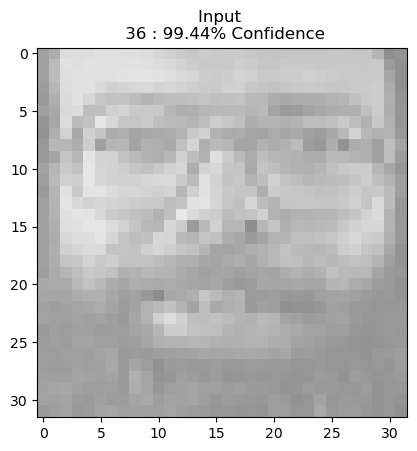

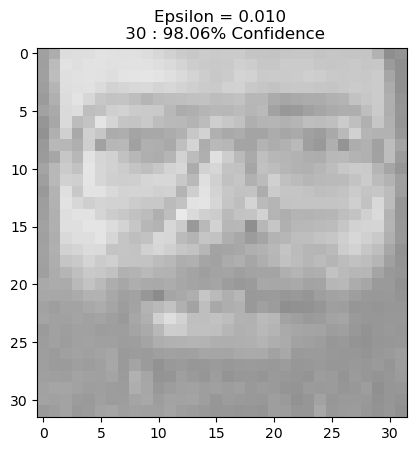

In [216]:
eps = 0.01

for i in range(x_test.shape[0]):
    image = tf.expand_dims(x_test[i], 0)
    label = tf.expand_dims(y_test[i], 0)
    if(tf.argmax(model.predict(image, verbose=0), -1)[0] == tf.argmax(label, -1)[0]):
        perturbations = create_adversarial_pattern(image, label, model)
        adv_x = image + eps*perturbations
        if(tf.argmax(model.predict(image, verbose=0), -1)[0] != tf.argmax(model.predict(adv_x, verbose=0), -1)[0]):
            print("True Label : {}".format(tf.argmax(label, -1)[0].numpy()))
            img_label = i
            break

epsilons = [0, eps]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i], model)

Adversarial Training

In [217]:
def generate_adv(img, label, model, epsilon = eps):
    img = tf.expand_dims(tf.constant(img, dtype=tf.float32), 0)
    label = tf.expand_dims(tf.one_hot(label, len(folders)), 0)
    perturbations = create_adversarial_pattern(image, label, model)
    return img + epsilon*perturbations

In [218]:
img_adv = [imgs[i] + generate_adv(imgs[i], labels[i], model)[0].numpy() for i in range(len(imgs))]

x_data_adv = imgs.copy()
x_data_adv.extend(img_adv)
y_data_adv = labels.copy()
y_data_adv.extend(labels.copy())

x_train_adv, x_test_adv, y_train_adv, y_test_adv = train_test_split(x_data_adv, y_data_adv, test_size=0.2, random_state=1207)

x_train_adv = tf.constant(x_train_adv, dtype=tf.float32)
x_test_adv = tf.constant(x_test_adv, dtype=tf.float32)
y_train_adv = tf.one_hot(y_train_adv, len(folders))
y_test_adv = tf.one_hot(y_test_adv, len(folders))

assert x_train_adv.shape[0] == y_train_adv.shape[0]
assert x_test_adv.shape[0] == y_test_adv.shape[0]


In [219]:
model_adv = Model()
model_adv.compile(keras.optimizers.Adam(), tf.losses.categorical_crossentropy, tf.metrics.categorical_accuracy)

history_adv = model_adv.fit(x_train_adv, y_train_adv, batch_size=8, epochs=100, validation_split=0.2)

Epoch 1/100
64/64 [==============================] - 2s 7ms/step - loss: 3.6937 - categorical_accuracy: 0.0098 - val_loss: 3.6945 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
64/64 [==============================] - 0s 5ms/step - loss: 3.6899 - categorical_accuracy: 0.0254 - val_loss: 3.6945 - val_categorical_accuracy: 0.0000e+00
Epoch 3/100
64/64 [==============================] - 0s 5ms/step - loss: 3.6890 - categorical_accuracy: 0.0156 - val_loss: 3.6946 - val_categorical_accuracy: 0.0000e+00
Epoch 4/100
64/64 [==============================] - 0s 6ms/step - loss: 3.6861 - categorical_accuracy: 0.0273 - val_loss: 3.7057 - val_categorical_accuracy: 0.0000e+00
Epoch 5/100
64/64 [==============================] - 0s 5ms/step - loss: 3.6836 - categorical_accuracy: 0.0273 - val_loss: 3.7054 - val_categorical_accuracy: 0.0000e+00
Epoch 6/100
64/64 [==============================] - 0s 6ms/step - loss: 3.6804 - categorical_accuracy: 0.0234 - val_loss: 3.7067 - val_categorical_accurac

In [220]:
model_adv.evaluate(x_test, y_test)

5/5 [==============================] - 0s 7ms/step - loss: 0.9154 - categorical_accuracy: 0.9312


[0.915355384349823, 0.9312499761581421]

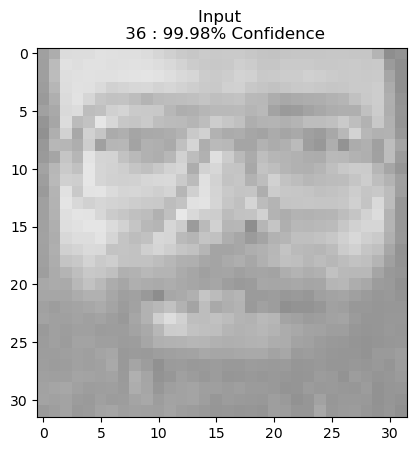

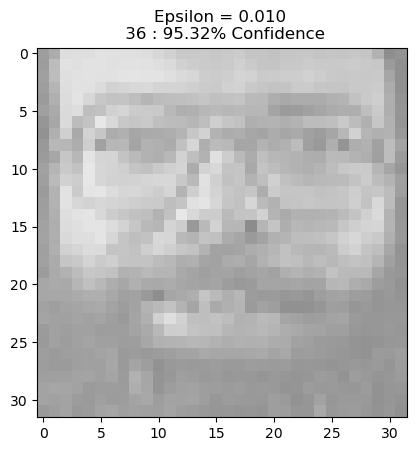

In [221]:
perturbations = create_adversarial_pattern(image, label, model_adv)
adv_x = image + eps*perturbations

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i], model_adv)

In [224]:
count_correct = 0
count_origin_attack = 0
count_adv_attack = 0

for i in range(x_test.shape[0]):
    image = tf.expand_dims(x_test[i], 0)
    label = tf.expand_dims(y_test[i], 0)
    if(tf.argmax(model.predict(image, verbose=0), -1)[0] == tf.argmax(label, -1)[0]):
        count_correct = count_correct + 1
        perturbations = create_adversarial_pattern(image, label, model)
        adv_x = image + eps*perturbations
        if(tf.argmax(model.predict(image, verbose=0), -1)[0] != tf.argmax(model.predict(adv_x, verbose=0), -1)[0]):
            count_origin_attack = count_origin_attack + 1
        if(tf.argmax(model_adv.predict(image, verbose=0), -1)[0] != tf.argmax(model_adv.predict(adv_x, verbose=0), -1)[0]):
                count_adv_attack = count_adv_attack + 1    

In [225]:
print("Origin Successful Attack Rate : {}".format(count_origin_attack / count_correct))
print("Adversarial Training Successful Attack Rate : {}".format(count_adv_attack / count_correct))

Origin Successful Attack Rate : 0.2792207792207792
Adversarial Training Successful Attack Rate : 0.05194805194805195
